### Set-Up

In [1]:
!pip install networkx
!pip install numpy
!pip install matplotlib

from IPython.display import clear_output
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import itertools
import math

clear_output()
print('All packages installed')

All packages installed


In [2]:
!pip install networkx
!pip install numpy
!pip install matplotlib

from IPython.display import clear_output
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import itertools
import math

clear_output()
print('All packages installed')

All packages installed


In [3]:
def generate_SBM_graph(
    num_blocks=4,
    block_size_min=5, 
    block_size_max=15,
    p_within_range=(0.6, 0.8),
    p_between_range=(.015, 0.05),
    tasked_percentage=.2,
):
    '''
    Generates a SMB graph from specified sizes and probabilities
    
    Parameters
    ----
    len(blocks): number of blocks
    block_size_min: minimum number of nodes in each block
    block_size_max: maximum number of nodes in each block
    p_within_range: range for edge probabilities within blocks
    p_between_range: range for edge probabilities between blocks
    tasked_percentage: .2

    Requires
    ----
    - numpy "np"
    - NetworkX "nx"
    - defaultdict

    Returns
    ----
    [0] The NetworkX SBM graph
    [1] A list of nodes to task
    [2] Array of spring layout positions
    [3] Edge probability matrix
    [4] Block lists of nodes
    '''
    
    # Generate random probabilities for within-block edges
    p_within = np.random.uniform(*p_within_range, size=num_blocks)
    
    # Generate random probabilities for between-block edges
    p_between = np.random.uniform(*p_between_range, size=(num_blocks, num_blocks))
    
    # Make between-block probabilities symmetric using upper triangle
    p_between = np.triu(p_between)
    p_between = p_between + p_between.T - np.diag(np.diag(p_between))
    
    # Create a block probability matrix
    prob_matrix = p_between
    np.fill_diagonal(prob_matrix, np.random.uniform(*p_within_range, num_blocks))
    
    # Create sizes list for each block (number of nodes per block)
    sizes = np.random.randint(block_size_min, block_size_max, size=num_blocks)
    
    # Create the stochastic block model graph
    G = nx.stochastic_block_model(sizes, prob_matrix)
    
    # Randomly task nodes
    tasked_nodes = np.random.randint(len(G), size=int(len(G)*tasked_percentage)).tolist()

    # Get positions
    pos = nx.spring_layout(G)

    # Get blocks
    block_membership = nx.get_node_attributes(G, 'block')
    blocks = defaultdict(list)
    [blocks[block].append(node) for node, block in block_membership.items()]
    blocks = list(blocks.values())

    return G, tasked_nodes, pos, prob_matrix, blocks

In [4]:
def visualize_graph_blocks(
    G,  
    pos,
    tasked_nodes=None
):
    '''
    Draw a graph colored by blocks with tasked nodes highlighted
    
    Parameters
    ----
    G: Graph to visualize 
    pos: Array of positions of nodes from nx layouts
    tasked_nodes: List of tasked nodes

    Requires
    ----
    - NetworkX "nx"
    - matplotlib.pyplot "plt"

    Returns
    ----
    '''
    
    # Get node colors based on their block assignment for viz
    node_colors = []
    for block_id in nx.get_node_attributes(G, 'block').values():
        node_colors.append(block_id)
    
    # Get color map for blocks
    color_map = plt.get_cmap('spring', len(blocks))

    # Color tasked borders
    tasked_colors = {node: 'black' for node in tasked_nodes}
    tasked_colors.update({node: 'white' for node in G.nodes if node not in tasked_colors})
    edge_colors = [tasked_colors.get(node, 'black') for node in G.nodes]
    
    # Plot the graph
    nx.draw(
        G, 
        pos, 
        with_labels=True, 
        node_size=200, 
        width=.5, 
        node_color=node_colors, 
        edgecolors=edge_colors, 
        cmap=color_map, 
        edge_color='gray'
    )
    plt.show()

In [5]:
def make_subgraph(
    G,
    remove_edges
):
    '''
    Creates a subgraph from a graph with specified edges removed
    
    Parameters
    ----
    G: Graph to get a subgraph of
    remove_edges: List of edges to remove

    Requires
    ----
    - NetworkX "nx"

    Returns
    ----
    [0] List of subgraph, number of lost nodes, number of lost edges
    '''
    G_new = G.copy()
    G_new.remove_edges_from(remove_edges)

    return [G_new, len(G)-len(G_new), G.size()-G_new.size()]

In [6]:
def sample_status_edges(
    G, 
    tasked_nodes,
    sample_percent=.5
):
    '''
    Samples edges adjacent to tasked and untasked nodes
    
    Parameters
    ----
    G: Graph to sample edges from
    tasked_nodes: List of tasked nodes
    sample_percent: Decimal percent of edges to sample

    Requires
    ----
    - NetworkX "nx"
    - random

    Returns
    ----
    [0] List of tasked edges sample
    [1] List of untasked edges sample
    '''
    # Get sample of edges adjacent to tasked nodes
    tasked_edges = [(u, v) for u, v in G.edges() if u in tasked_nodes or v in tasked_nodes]
    tasked_edges_sample = random.sample(tasked_edges, int(len(tasked_edges)*sample_percent))

    # Get sample of edges not adjacent to tasked nodes of same size
    untasked_edges = [edge for edge in list(G.edges) if edge not in tasked_edges]
    untasked_edges_sample = random.sample(untasked_edges, len(tasked_edges_sample))

    return tasked_edges_sample, untasked_edges_sample

In [7]:
def sample_block_edges(
    G,
    blocks, 
    comm_sample_percent=.5,
    edge_sample_percent=.9,
    one_community=False
):
    '''
    Samples the same number of edges for edges between blocks, within blocks, and within one block
    
    Parameters
    ----
    G: Graph to sample from
    blocks: List of lists of nodes in blocks
    comm_sample_percent: Decimal percent to sample from community pairs
    edge_sample_percent: Decimal percent to sample edges
    one_community: Get sample from one community if true, otherwise empty list

    Requires
    ----
    - NetworkX "nx"
    - itertools
    - random

    Returns
    ----
    [0] List of between block edges sample
    [1] List of within block edges sample
    [2] List of within one block sample
    '''
    G_within = G.copy()
    
    # Get sample of community pairs
    unique_pairs = list(itertools.combinations(blocks, 2))
    sample_pairs = random.sample(unique_pairs, int(len(unique_pairs)*comm_sample_percent))

    # Sample edges between the sample of community pairs while building G_within
    between_edges_sample = []
    for pair in sample_pairs:
        between_edges = list(nx.edge_boundary(G, pair[0], pair[1]))
        between_edges_sample = between_edges_sample + random.sample(between_edges, int(len(between_edges)*edge_sample_percent))
        G_within.remove_edges_from(between_edges)
    
    # Sample from the sample of communities
    within_edges_sample = random.sample(list(G_within.edges()), len(between_edges_sample))

    # Sample within edges
    if one_community: # sample from one community
        within_edges_pairs = list(G.subgraph(blocks[0]).edges())
        within_edges_comm_sample = random.sample(within_edges_pairs, len(between_edges_sample))
    else: 
        within_edges_comm_sample = []
        
    return between_edges_sample, within_edges_sample, within_edges_comm_sample

### Run Everything

In [8]:
G, tasked_nodes, pos, prob_matrix, blocks = generate_SBM_graph()

In [9]:
prob_matrix

array([[0.72515274, 0.03702597, 0.03762504, 0.0344006 ],
       [0.03702597, 0.75385234, 0.02440217, 0.02548787],
       [0.03762504, 0.02440217, 0.79691688, 0.02544436],
       [0.0344006 , 0.02548787, 0.02544436, 0.68380119]])

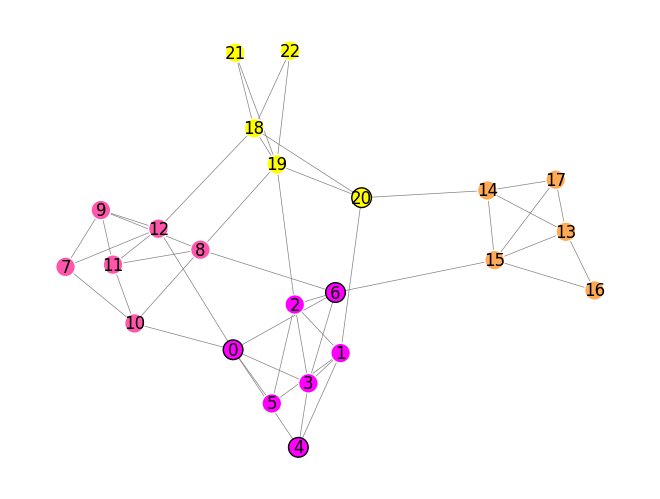

In [10]:
visualize_graph_blocks(G, pos, tasked_nodes)

In [11]:
tasked_nodes

[20, 6, 0, 4]

#### Pagerank

In [12]:
subgraphs1 = {}
subgraphs1['Full'] = [G, 0, 0]

##### Effect on tasked nodes

In [13]:
# Drop sample of edges adjacent to tasked nodes
tasked_edges_sample, untasked_edges_sample = sample_status_edges(G, tasked_nodes)
subgraphs1['Drop Tasked'] = make_subgraph(G, tasked_edges_sample)

# Drop sample of edges not adjacent to tasked nodes
subgraphs1['Drop Untasked'] = make_subgraph(G, untasked_edges_sample)

In [14]:
# Drop random sample of edges
random_edges_sample_pr = random.sample(list(G.edges()), len(tasked_edges_sample))
subgraphs1['Drop Random'] = make_subgraph(G, random_edges_sample_pr)

##### Effect on within/between block edges

In [15]:
# Get between and within block edge samples
between_edges_sample_pr, within_edges_sample_pr, _ = sample_block_edges(G, blocks)

# Drop sample of edges between blocks
subgraphs1['Drop Between'] = make_subgraph(G, between_edges_sample_pr)

# Drop sample of edges within blocks
subgraphs1['Drop Within'] = make_subgraph(G, within_edges_sample_pr)

##### Visualizations of resulting subgraphs

In [16]:
subgraphs1

{'Full': [<networkx.classes.graph.Graph at 0x1be7fdc5f40>, 0, 0],
 'Drop Tasked': [<networkx.classes.graph.Graph at 0x1be7fed8d10>, 0, 8],
 'Drop Untasked': [<networkx.classes.graph.Graph at 0x1be7fdc51f0>, 0, 8],
 'Drop Random': [<networkx.classes.graph.Graph at 0x1be7fed9ca0>, 0, 8],
 'Drop Between': [<networkx.classes.graph.Graph at 0x1be7fd30a70>, 0, 3],
 'Drop Within': [<networkx.classes.graph.Graph at 0x1be7fe9af60>, 0, 3]}

Full


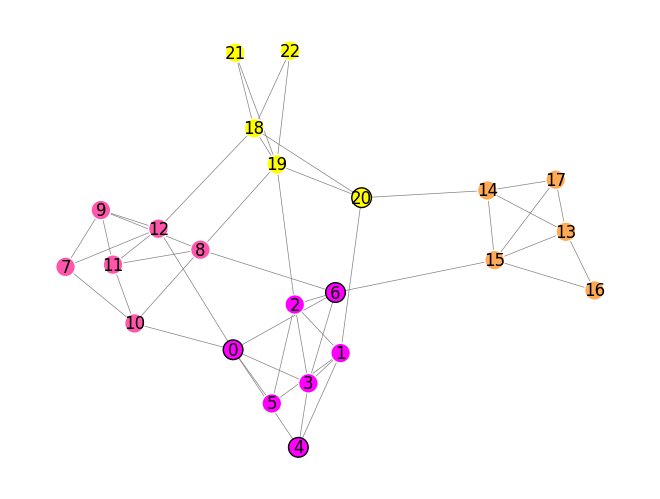

Drop Tasked


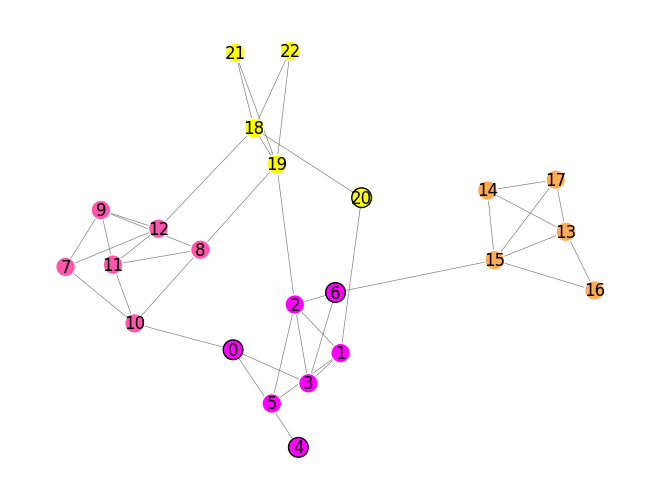

Drop Untasked


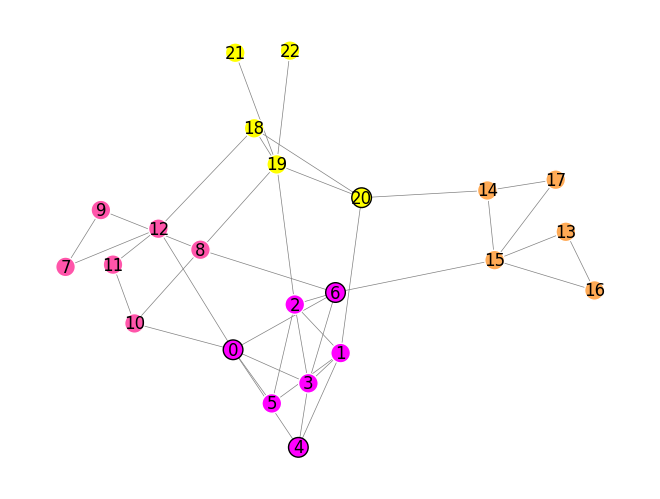

Drop Random


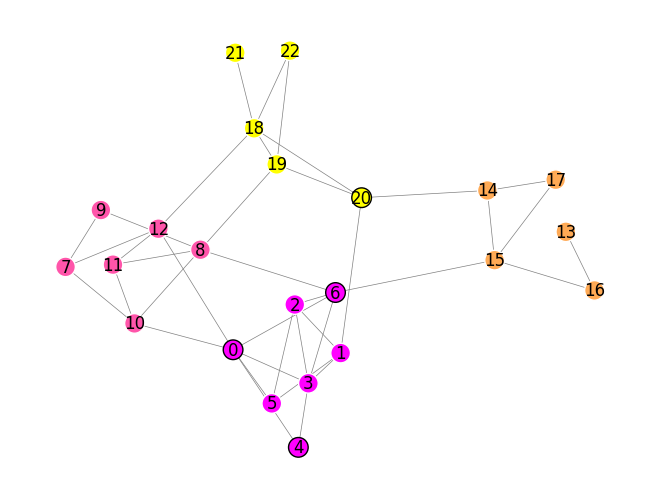

Drop Between


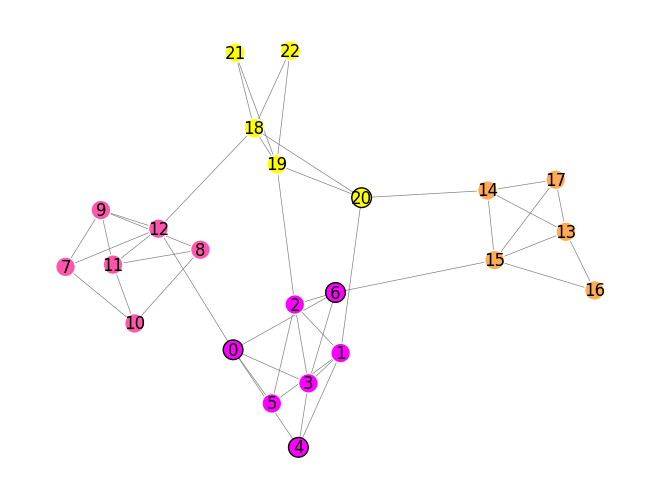

Drop Within


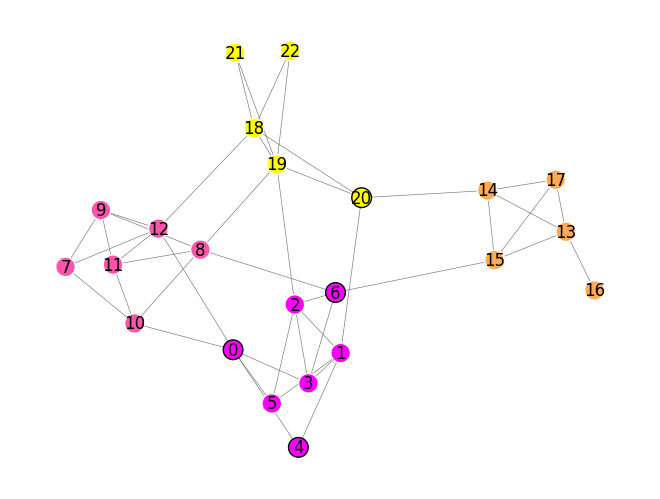

In [17]:
for test in subgraphs1:
    print(test)
    visualize_graph_blocks(subgraphs1[test][0], pos, tasked_nodes)

#### Connectivity

In [18]:
subgraphs2 = {}
subgraphs2['Full'] = [G, 0, 0]

In [19]:
# Get between and within block edge samples
between_edges_sample_connect, within_edges_sample_connect, _ = sample_block_edges(G, blocks)

# Drop sample of edges between blocks
subgraphs2['Drop Between'] = make_subgraph(G, between_edges_sample_connect)

# Drop sample of edges within blocks
subgraphs2['Drop Within'] = make_subgraph(G, within_edges_sample_connect)

In [20]:
# Drop random sample of edges
random_edges_sample_connect = random.sample(list(G.edges()), len(between_edges_sample_connect))
subgraphs2['Drop Random'] = make_subgraph(G, random_edges_sample_connect)

In [21]:
# Disconnect blocks
disconnect_sample_connect, _, _ = sample_block_edges(G, blocks, comm_sample_percent=1, edge_sample_percent=1)
subgraphs2['Disconnect'] = make_subgraph(G, disconnect_sample_connect)

In [22]:
subgraphs2

{'Full': [<networkx.classes.graph.Graph at 0x1be7fdc5f40>, 0, 0],
 'Drop Between': [<networkx.classes.graph.Graph at 0x1be7fed8a70>, 0, 2],
 'Drop Within': [<networkx.classes.graph.Graph at 0x1be1107b980>, 0, 2],
 'Drop Random': [<networkx.classes.graph.Graph at 0x1be1165aae0>, 0, 2],
 'Disconnect': [<networkx.classes.graph.Graph at 0x1be7fdc7800>, 0, 9]}

Full


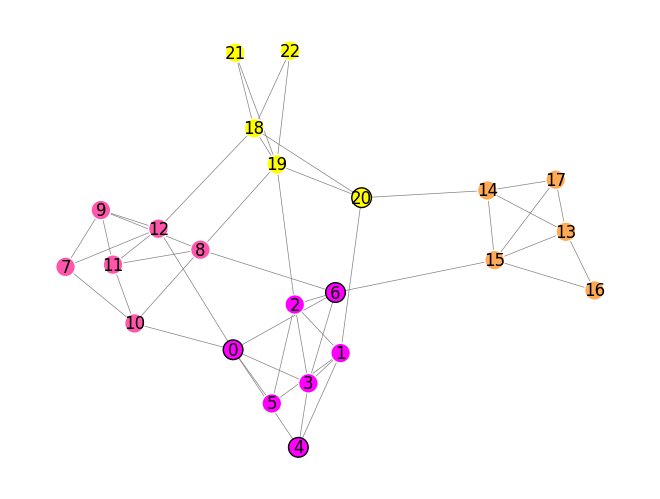

Drop Between


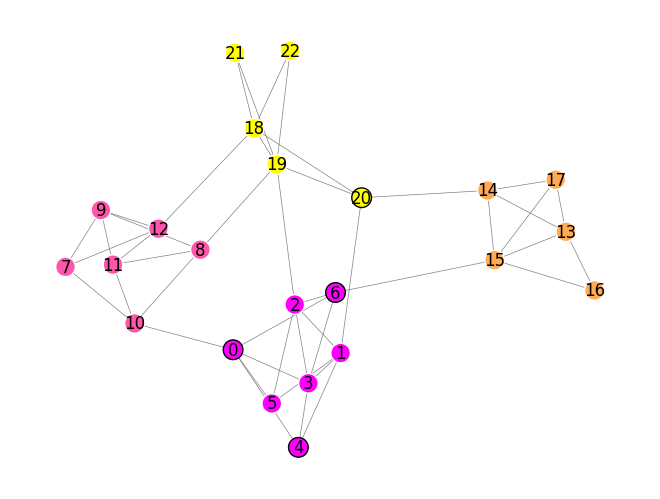

Drop Within


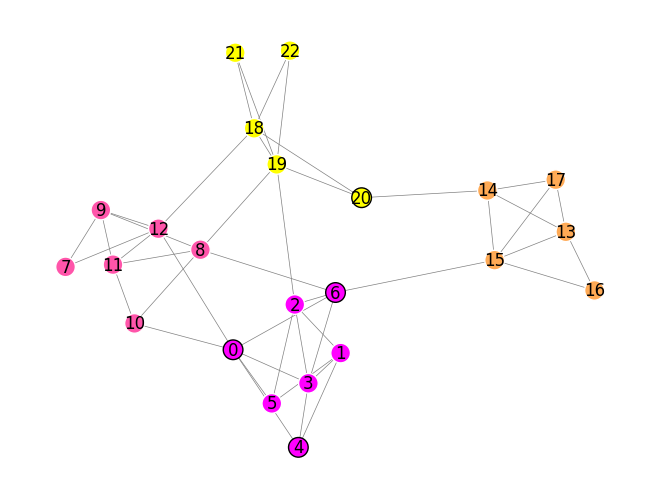

Drop Random


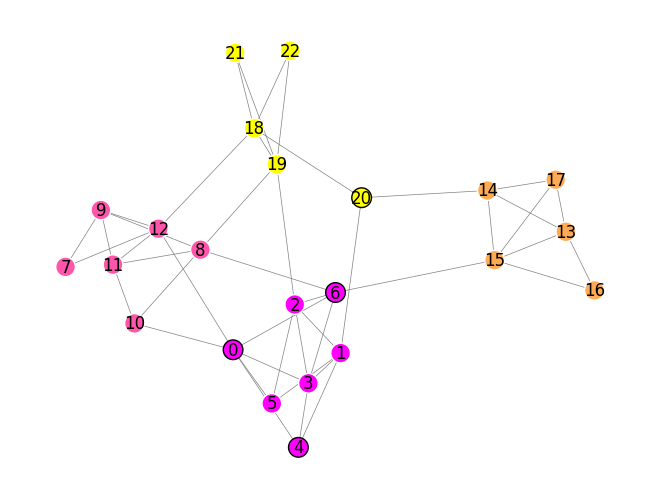

Disconnect


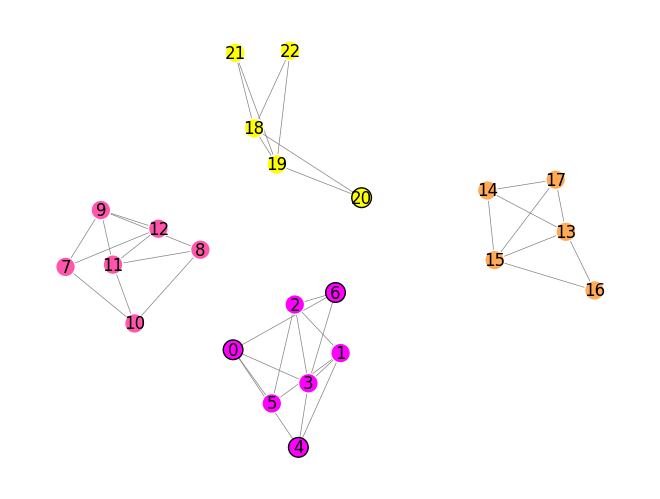

In [23]:
for test in subgraphs2:
    print(test)
    visualize_graph_blocks(subgraphs2[test][0], pos, tasked_nodes)

#### Community

In [24]:
subgraphs3 = {}
subgraphs3['Full'] = [G, 0, 0]

In [25]:
# Get between and within block edge samples
between_edges_sample_comm, within_edges_sample_comm, within_edges_one_comm = sample_block_edges(
    G, blocks, comm_sample_percent=1, edge_sample_percent=.5, one_community=True)

# Drop edges within one community
subgraphs3['Within One'] = make_subgraph(G, within_edges_one_comm)

# Drop edges within all communities
subgraphs3['Within All'] = make_subgraph(G, within_edges_sample_comm)

# Drop edges between all communities
subgraphs3['Between'] = make_subgraph(G, between_edges_sample_comm)

In [26]:
# Drop random sample of edges
random_edges_sample_comm = random.sample(list(G.edges()), len(between_edges_sample_comm))
subgraphs3['Drop Random'] = make_subgraph(G, random_edges_sample_comm)

Full


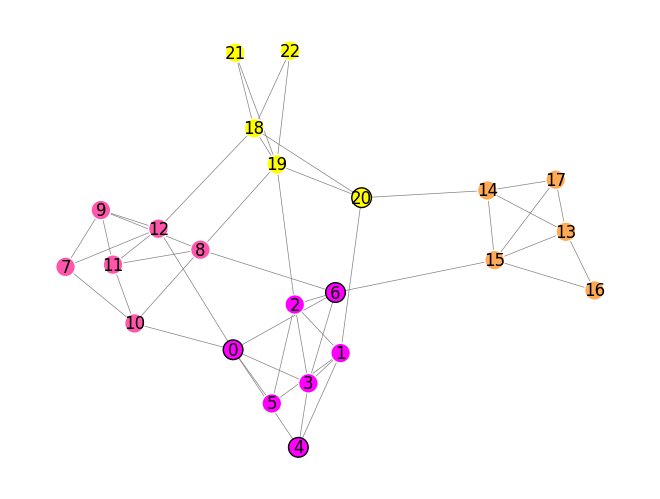

Within One


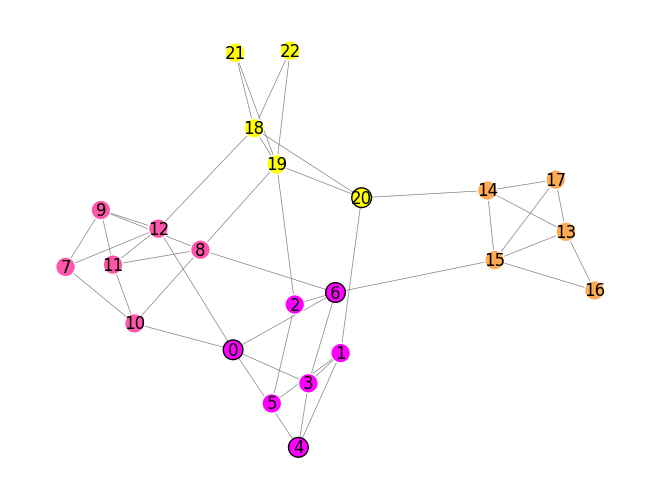

Within All


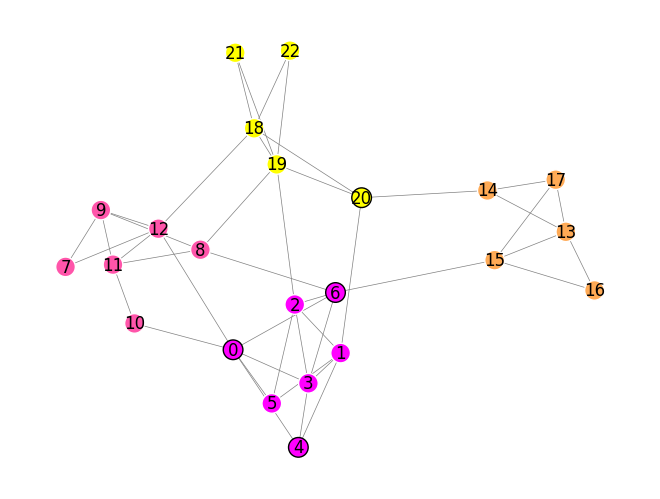

Between


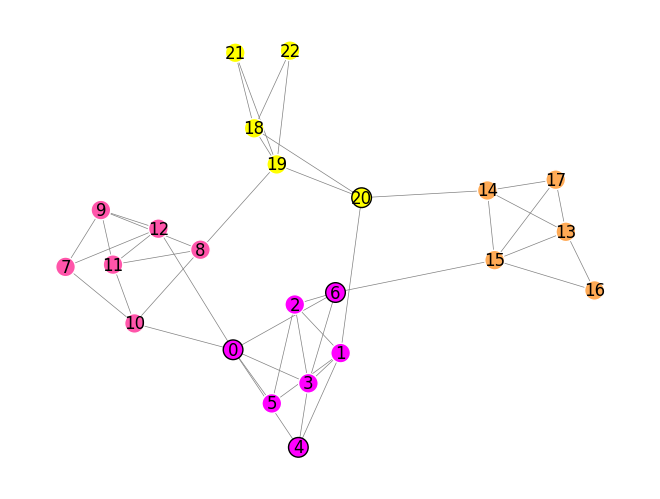

Drop Random


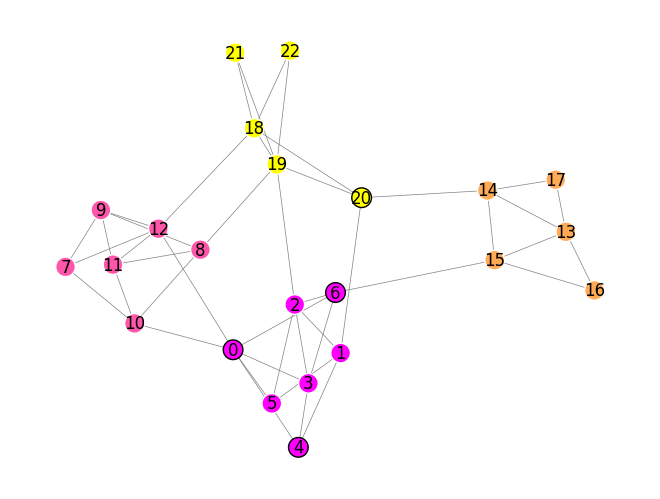

In [27]:
for test in subgraphs3:
    print(test)
    visualize_graph_blocks(subgraphs3[test][0], pos, tasked_nodes)